## Задание.

Таблица содержит 11 столбцов чисел. Первые 10 столбцов - входные переменные (x_1 , …. , x_10), 11-й столбец - выходная прогнозируемая переменная y. Каждая строка в файле - это один обучающий пример для построения статистической модели для зависимости y = y(x_1,x_2,..,x_10). Конкретный вид связи между выходной и входными переменными не известен.

Требуется провести разведочный анализ данных, выбрать критерий для точности модели, и указать степень важности (информативности) каждой из 10 входных переменных с точки зрения точности модели. 

Что еще можно предложить чтобы улучшить получившийся результат?

In [1]:
#Необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,\
                                                    validation_curve, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import os

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Jupyter notebook находится в той же директории, что и файл с данными
os.listdir()

['.ipynb_checkpoints', 'accenture-data', 'accenture_test_task.ipynb']

In [3]:
# Загрузка данных в pandas DataFrame

data = pd.read_csv('accenture-data/accenture_text.txt', sep ='\t', header=None)
print(data.shape)
data.head()

(1000, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,0.155051,0.974187,0.074675,0.442146,0.369443,0.468138,0.578846,0.422744,0.931543,0.474148,15
1,0.968379,0.716820,0.678846,0.510049,0.545299,0.573692,0.817491,0.206636,0.880111,0.574187,17
2,0.468263,0.405603,0.320325,0.468084,0.100995,0.974407,0.300062,0.608356,0.050082,0.762011,12
3,0.776820,0.103740,0.373748,0.797782,0.906810,0.599069,0.626680,0.924705,0.632768,0.512663,16
4,0.407886,0.415357,0.101543,0.935160,0.444124,0.193607,0.656837,0.599929,0.868582,0.405406,20


In [4]:
# Пропущенных значений нет, целевая переменная целочисленная
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
0     1000 non-null float64
1     1000 non-null float64
2     1000 non-null float64
3     1000 non-null float64
4     1000 non-null float64
5     1000 non-null float64
6     1000 non-null float64
7     1000 non-null float64
8     1000 non-null float64
9     1000 non-null float64
10    1000 non-null int64
dtypes: float64(10), int64(1)
memory usage: 86.0 KB


In [5]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.490491,0.499785,0.496466,0.503167,0.508902,0.513466,0.487111,0.498870,0.505611,0.499113,15.014000
std,0.293920,0.278833,0.298024,0.284102,0.283300,0.291059,0.288407,0.285954,0.283131,0.284073,4.771223
min,0.000188,0.000085,0.003110,0.001223,0.005314,0.000517,0.000493,0.000408,0.007883,0.000170,3.000000
25%,0.218825,0.262168,0.231492,0.268925,0.274572,0.255524,0.237778,0.256103,0.262332,0.249675,12.000000
50%,0.504439,0.500901,0.484347,0.503412,0.508629,0.527155,0.475274,0.501300,0.518847,0.509422,15.000000
75%,0.738004,0.734516,0.764729,0.747587,0.742461,0.766870,0.738885,0.736849,0.748473,0.741870,18.000000
max,0.999566,0.999959,0.998918,0.998785,0.998478,0.999059,0.999179,0.998646,0.998884,0.998819,29.000000


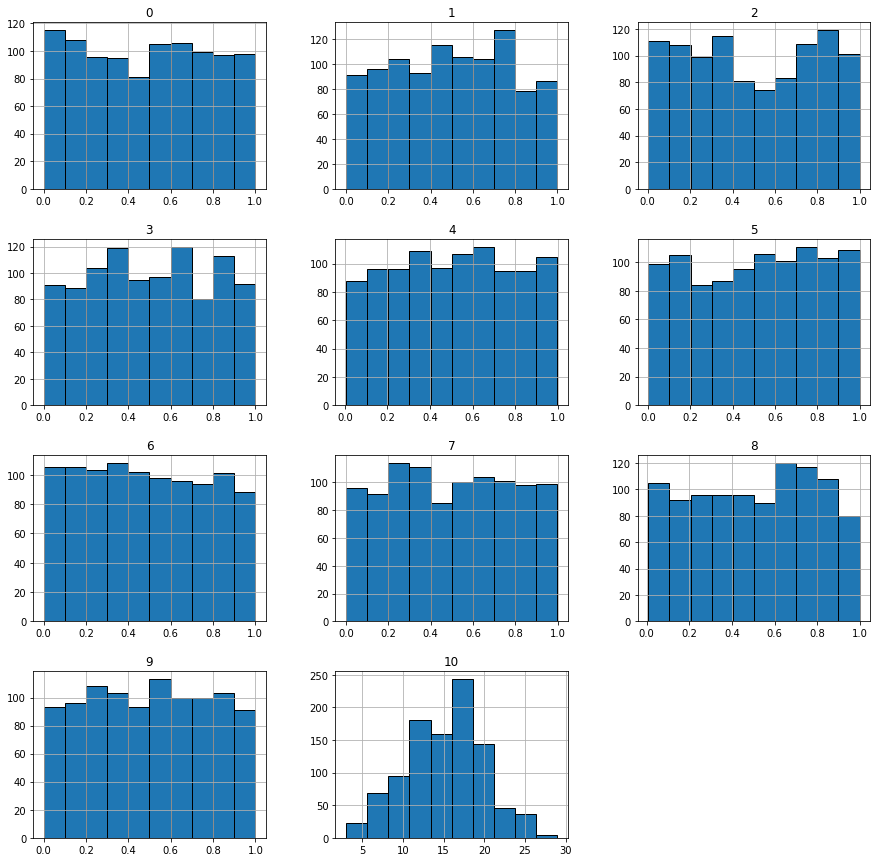

In [6]:
data.hist(bins=10, figsize=(15, 15), ec = 'k')
plt.show()

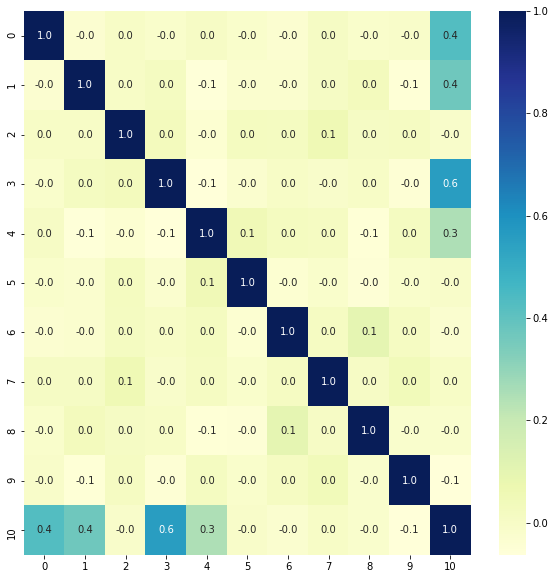

In [7]:
# Корреляции между признаками и целевой переменной
# Признаки 0, 1, 3, 4 имеют более выраженную по сравнению с остальными корреляцию с целевой переменной

plt.figure(figsize=[10, 10])
ax = sns.heatmap(data.corr(), 
                 fmt = ".1f", cmap='YlGnBu', cbar = True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),)
ax.set_yticklabels(ax.get_yticklabels(),)
sns.set(font_scale=1.4)
plt.show()

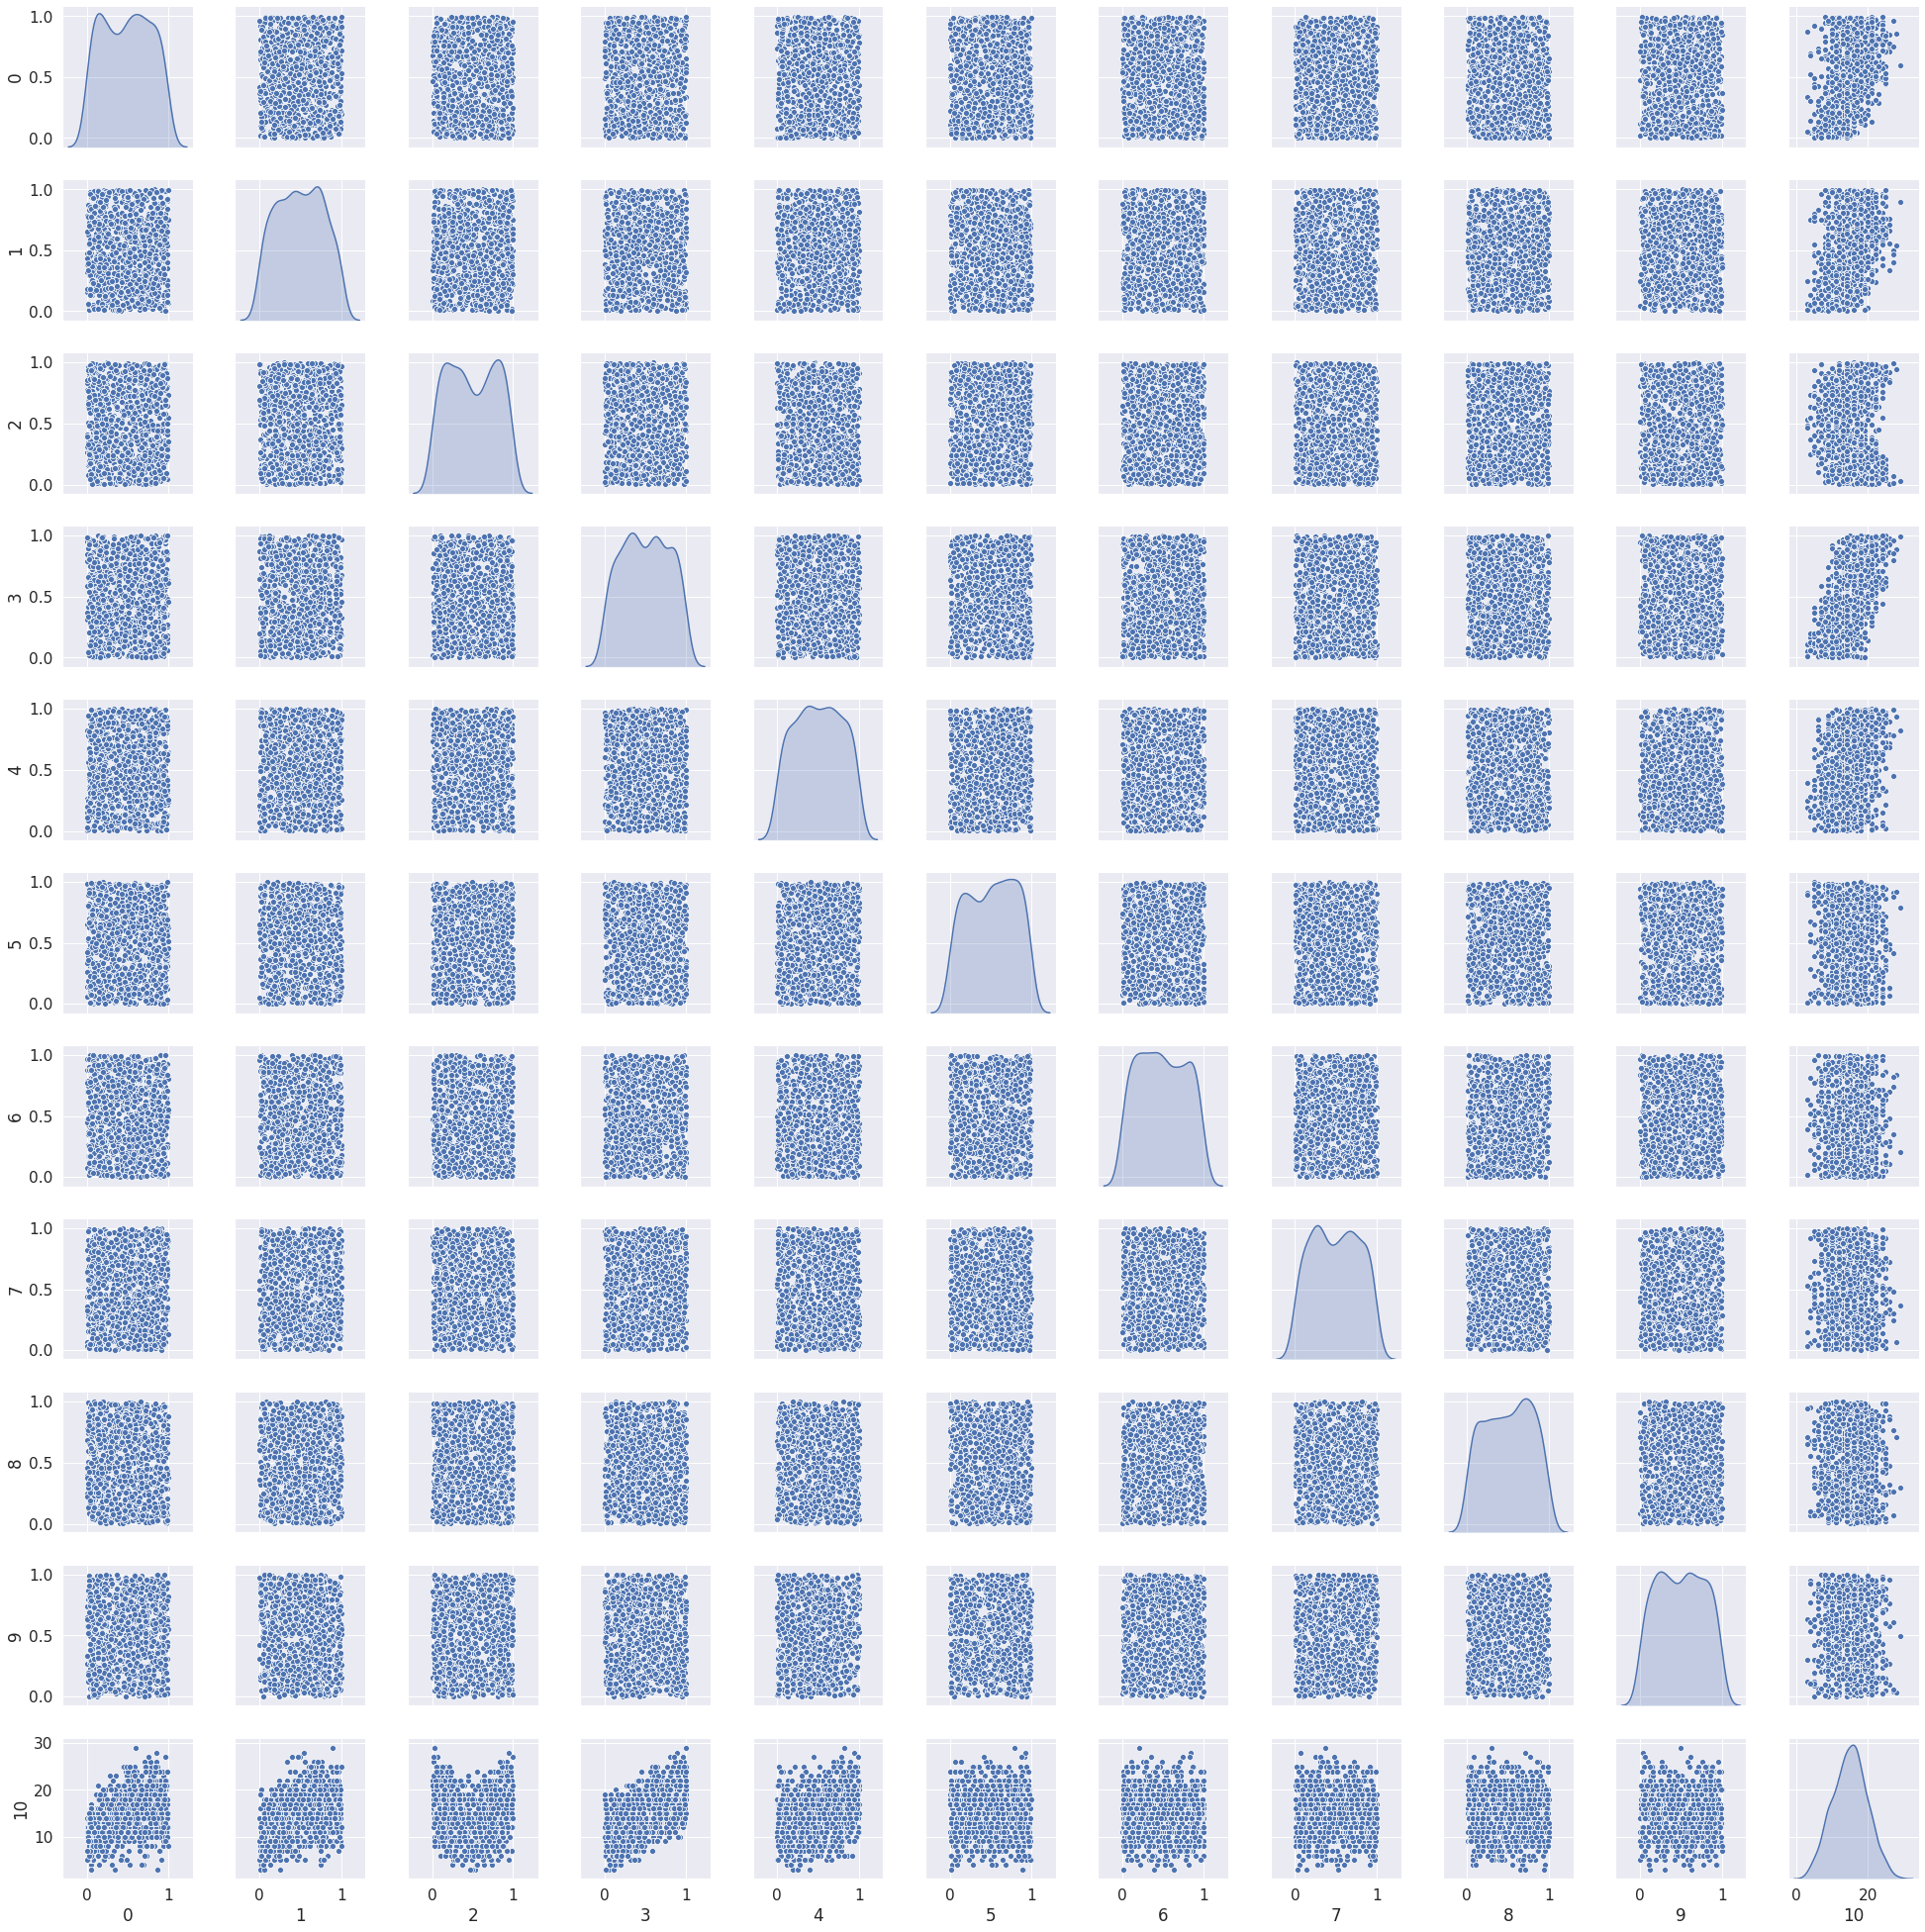

In [8]:
# Из графиков зависимостей так же можно отметить признак №3

sns.pairplot(data, diag_kind='kde')
plt.show()

In [9]:
# Разделим выборку на тестовую и обучающую

X_train, X_test, \
y_train, y_test = train_test_split(data.drop(10, axis=1), data[10],
                                   test_size=0.4,
                                   shuffle=True, random_state=42)

# Выбор метрики:

Для данной задачи регресии будем использовать метрику R2 (коэффициент детерминации).
Данная метрика позволяет оценить долю дисперсии целевой переменной, объясняемую рассматриваемой моделью.

## Модель линейной регрессии:

In [10]:
scaler = StandardScaler()
linearmodel = LinearRegression()

pipeline = Pipeline([('scaler', scaler),
                     ('linear_reg', linearmodel)])

In [11]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
print('R2 на кросс-валидации: ',
      np.mean(cross_val_score(pipeline, X_train, y_train, cv=5,
                              scoring='r2',
                              n_jobs=-1, verbose=0)))

R2 на кросс-валидации:  0.7359948386358877


In [13]:
pipeline.fit(X_train, y_train)
print('''Абсолютные значения коэффициентов линейной регрессии, 
отсортированные по степени важности от наименее важного к наиболее важному:''')
pd.DataFrame(np.abs(pipeline.named_steps['linear_reg'].coef_),
             np.arange(10), columns=['coef']).sort_values(by='coef')

Абсолютные значения коэффициентов линейной регрессии, 
отсортированные по степени важности от наименее важного к наиболее важному:


,coef
6,0.015008
5,0.034789
7,0.050799
9,0.059263
2,0.086165
8,0.110772
4,1.448612
1,1.821369
0,2.173083
3,2.708297


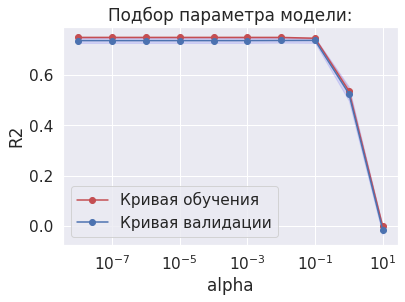

In [14]:
# На первый взгляд линейная модель хорошо описывает данные (R2 = 0.735). 
# Обучим Лассо с подбором параметра alpha:

model_lasso = Lasso(random_state=42)

pipeline = Pipeline([('scaler', scaler),
                     ('lasso', model_lasso)])

alphas=np.logspace(1, -8, 10)
train_scores, valid_scores = validation_curve(pipeline, X_train, 
                                              y_train, "lasso__alpha", 
                                              alphas, cv=5,
                                              scoring='r2'
                                             )

plt.plot(alphas, train_scores.mean(axis=1), 'ro-', label='Кривая обучения')

plt.fill_between(x=alphas, y1=train_scores.max(axis=1), 
                 y2=train_scores.min(axis=1), alpha=0.1, color = "red")


plt.plot(alphas, valid_scores.mean(axis=1), 'bo-', label='Кривая валидации')

plt.fill_between(x=alphas, y1=valid_scores.max(axis=1), 
                 y2=valid_scores.min(axis=1), alpha=0.1, color = "blue")

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('R2')
plt.title('Подбор параметра модели:')
plt.legend()

plt.show()

In [15]:
best_a = alphas[np.argmax(valid_scores.mean(axis=1))]
print('Лучшая alpha: ', best_a)
print('R2: ', np.max(valid_scores.mean(axis=1)))

Лучшая alpha:  0.1
R2:  0.7368255568185758


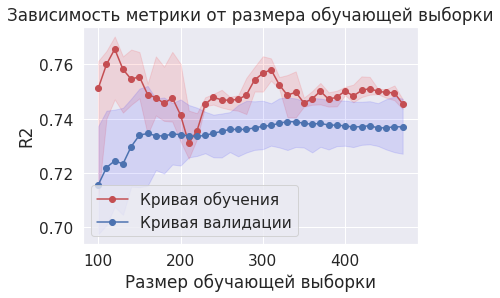

In [16]:
# Посмотрим как влияет на качеcтво модели увеличение датасета:

model_lasso = Lasso(alpha=best_a, random_state=42)

pipeline = Pipeline([('scaler', scaler),
                     ('lasso', model_lasso)])

train_sizes, train_scores, valid_scores = learning_curve(pipeline, X_train,
                                                         y_train,
                                                         train_sizes=list(range(100,480,10)),
                                                         scoring='r2', 
                                                         cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), 'ro-', label='Кривая обучения')

plt.fill_between(x=train_sizes, y1=train_scores.max(axis=1), 
                 y2=train_scores.min(axis=1), alpha=0.1, color = "red")

plt.plot(train_sizes, valid_scores.mean(axis=1), 'bo-', label='Кривая валидации')

plt.fill_between(x=train_sizes, y1=valid_scores.max(axis=1), 
                 y2=valid_scores.min(axis=1), alpha=0.1, color = "blue")

plt.xlabel('Размер обучающей выборки')
plt.ylabel('R2')
plt.title('Зависимость метрики от размера обучающей выборки')
plt.legend()

plt.show()

Линейная модель практически не улучшается при увеличении выборки более 250 обучающих примеров.
Возможно, она не достаточно сложная для описания представленных данных.

Ниже так же представлены значения метрики R2 на кросс-валидации и на отложенной выборке.

In [17]:
Lasso_CV_score = np.mean(cross_val_score(pipeline,
                                           X_train,
                                          y_train, cv=5,
                                          scoring='r2',
                                          n_jobs=-1, verbose=0))

pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
Lasso_HO_score = r2_score(y_hat, y_test)

print('Lasso R2 на кросс-валидации:', Lasso_CV_score)
print('Lasso R2 на отложенной выборке:', Lasso_HO_score)

Lasso R2 на кросс-валидации: 0.7368255568185758
Lasso R2 на отложенной выборке: 0.5683510966167815


На отложенной выборке коэффициент детерминации гораздо ниже чем на кросс-валидации, как и предполагалось.

Имеет смысл попробовать нелинейные модели

## Случайный лес

In [18]:
model_rf=RandomForestRegressor(random_state=42)

In [19]:
%%time
# Обучим Случайный лес из "коробки":

cv_scores = cross_val_score(model_rf, X_train,
                            y_train, scoring='r2',cv=5, n_jobs=-1)

print('R2: ', cv_scores.mean())

R2:  0.8010058866430028
CPU times: user 48.3 ms, sys: 48 µs, total: 48.3 ms
Wall time: 839 ms


Метрика R2 на кросс-валидации для модели Случайный Лес лучше, чем для линейной модели.

Посмотрим на важность признаков для модели:

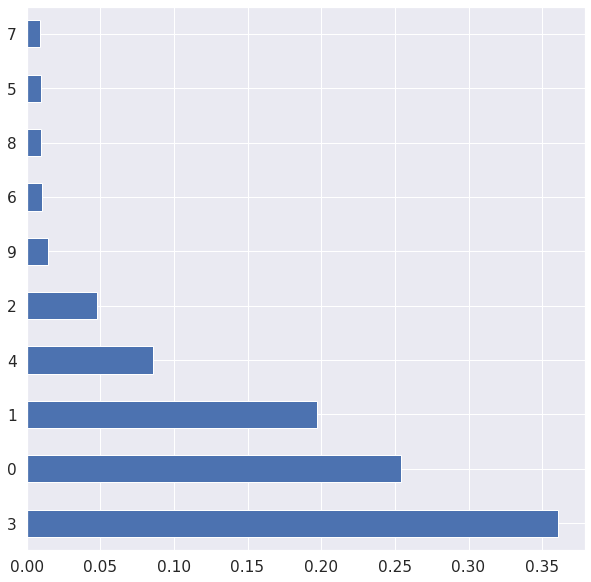

In [20]:
model_rf.fit(X_train, y_train)

plt.figure(figsize=[10, 10])
(pd.Series(model_rf.feature_importances_,
           index=X_train.columns).nlargest(10).plot(kind='barh'))
plt.show()

In [21]:
# Возьму 5 самых важных признаков и обучу на них Случайный лес,
# подобрав параметры модели по сетке:

param_grid={'max_depth':  [5, 10, 15],
            'max_features': np.arange(1,6)}

gs_rf=GridSearchCV(model_rf, param_grid, scoring='r2',
                n_jobs=-1, cv=5, verbose=1)
gs_rf.fit(X_train[[0, 1, 3, 4, 2]], y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
             

In [22]:
print('Лучшие параметры:')
print(gs_rf.best_params_)
print()
print('Метрика R2: ')
print(gs_rf.best_score_)

Лучшие параметры:
{'max_depth': 15, 'max_features': 4}

Метрика R2: 
0.8407049661337757


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.9s finished


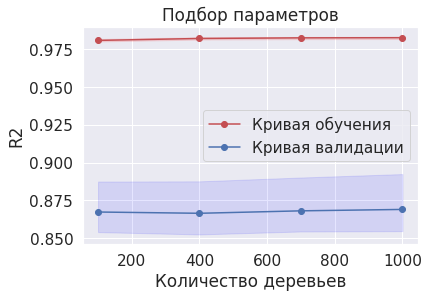

In [23]:
# Посмотрим, можно ли еще улучшить качество, увеличив количество деревьев:

model_rf=RandomForestRegressor(n_estimators=100,
                               max_depth=15,
                               max_features=3,
                               random_state=42)

n_estim=list(range(100,1001,300))
train_scores, valid_scores = validation_curve(model_rf, X_train[[0, 1, 3, 4, 2]], 
                                              y_train, 'n_estimators', 
                                              n_estim, cv=5, scoring='r2',
                                             verbose=1,
                                             n_jobs=-1)

plt.plot(n_estim, train_scores.mean(axis=1), 'ro-', label='Кривая обучения')

plt.fill_between(x=n_estim, y1=train_scores.max(axis=1), 
                 y2=train_scores.min(axis=1), alpha=0.1, color = "red")


plt.plot(n_estim, valid_scores.mean(axis=1), 'bo-', label='Кривая валидации')

plt.fill_between(x=n_estim, y1=valid_scores.max(axis=1), 
                 y2=valid_scores.min(axis=1), alpha=0.1, color = "blue")

plt.xlabel('Количество деревьев')
plt.ylabel('R2')
plt.title('Подбор параметров')
plt.legend()

plt.show()

In [24]:
best_n = n_estim[np.argmax(valid_scores.mean(axis=1))]
print('Количество деревьев: ', best_n)
print('Метрика R2 на валидации: ', np.max(valid_scores.mean(axis=1)))

Количество деревьев:  1000
Метрика R2 на валидации:  0.868936999737192


Ниже представлены метрики на кросс-валидации и отложенной выборке для лучшей модели Случайный Лес

In [25]:
model_rf=RandomForestRegressor(n_estimators=1000,
                               max_depth=15,
                               max_features=3,
                               random_state=42)

RandForest_CV_score = np.mean(cross_val_score(model_rf,
                                               X_train[[0, 1, 3, 4, 2]],
                                               y_train, cv=5,
                                               scoring='r2',
                                               n_jobs=-1, verbose=0))

model_rf.fit(X_train[[0, 1, 3, 4, 2]], y_train)
y_hat = model_rf.predict(X_test[[0, 1, 3, 4, 2]])
RandForest_HO_score = r2_score(y_hat, y_test)

print('RandomForest R2 на кросс-валидации:', RandForest_CV_score)
print('RandomForest R2 на отложенной выборке:', RandForest_HO_score)

RandomForest R2 на кросс-валидации: 0.868936999737192
RandomForest R2 на отложенной выборке: 0.8091541899198245


Разница между метриками на кросс-валидации и отложенной выборке 0.06.

Гораздо лучше линейной модели.

## Градиентный бустинг

Так же можно попробовать для решения данной задачи модель градиентного бустинга:

In [26]:
# XGBRegressor:

xgb_model = XGBRegressor(max_depth=25, learning_rate=0.1, 
                         n_estimators=100, n_jobs=-1,
                         seed=42)

print('XGBoost R2: ', np.mean(cross_val_score(xgb_model,
                                                X_train,
                                                y_train, cv=5,
                                                scoring='r2',
                                                n_jobs=-1, verbose=1)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


XGBoost R2:  0.8820236558706107


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [27]:
%%time
xgb_model.fit(X_train, y_train)

[20:54:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1.17 s, sys: 12.3 ms, total: 1.19 s
Wall time: 365 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=25, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=1, verbosity=1)

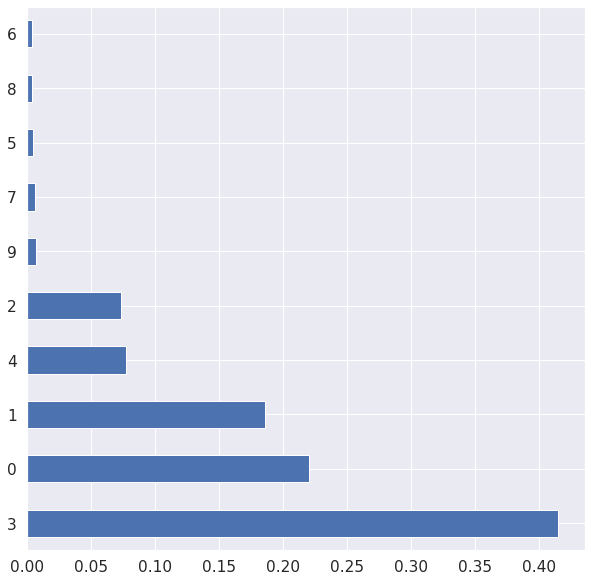

In [28]:
# Степень важности признаков в модели:

plt.figure(figsize=[10, 10])
(pd.Series(xgb_model.feature_importances_,
           index=X_train.columns).nlargest(10).plot(kind='barh'))
plt.show()

In [29]:
# Посмтрим качество при обучении на первых 5 признаках:

xgb_model = XGBRegressor(max_depth=25, learning_rate=0.1, 
                         n_estimators=100, n_jobs=-1,
                         seed=42)

print('XGBoost R2: ', np.mean(cross_val_score(xgb_model,
                                                X_train[[0, 1, 2, 3, 4]],
                                                y_train, cv=5,
                                                scoring='r2',
                                                n_jobs=-1, verbose=1)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


XGBoost R2:  0.9030792005638612


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [30]:
# Градиентный бустинг работает гораздо быстрее Случайного Леса. Качество на кросс-валидации так же лучше.
# Попробуем подобрать параметры, чтобы еще улучшить модель:

parameters_for_testing = {
    'colsample_bytree':[0.4, 0.6, 0.8],
    'gamma':[0, 0.01, 0.1],
    'min_child_weight':[1.5, 3, 5,10, 20],
    'learning_rate':[0.1,0.07, 0.05],
    'max_depth':[6, 10, 15, 20],
    'reg_alpha':[1e-5, 0.75],
    'reg_lambda':[1e-5, 0.45],
    'subsample':[0.6,0.95]  
}

xgb_model = XGBRegressor(n_estimators=100, n_jobs=-1,
                         seed=42)

gs_xgb_model = RandomizedSearchCV(estimator = xgb_model,
                             param_distributions=parameters_for_testing,
                            n_jobs=-1, iid=False, n_iter=100,
                            verbose=1,
                            scoring='r2',
                                  cv=5,
                                 random_state=42)

gs_xgb_model.fit(X_train[[0, 1, 2, 3, 4]], y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.6s finished


[20:55:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          random_s...
                   iid=False, n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.6, 0.8],
                                        'gamma': [0, 0.01, 

In [31]:
print('Параметры:')
print(gs_xgb_model.best_params_)
print()
print('R2:')
print(gs_xgb_model.best_score_)

Параметры:
{'subsample': 0.6, 'reg_lambda': 1e-05, 'reg_alpha': 1e-05, 'min_child_weight': 10, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.8}

R2:
0.944602368744764


In [32]:
xgb_model = XGBRegressor(colsample_bytree=0.8,
                         gamma=0.01,
                         learning_rate=0.1,
                         max_depth=20,
                         min_child_weight=10,
                         reg_alpha=1e-05,
                         reg_lambda=1e-05,
                         subsample=0.6,
                         n_estimators=100,
                         n_jobs=-1,
                         seed=42)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.2s finished


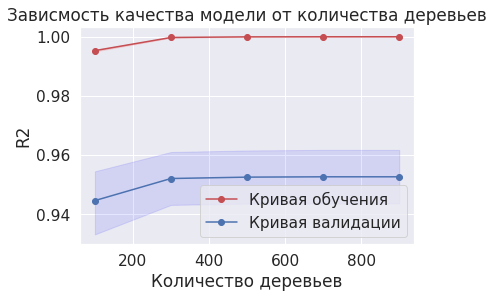

In [33]:
# Зависмость метрики от количества деревьев:

n_estim=list(range(100,1001,200))
train_scores, valid_scores = validation_curve(xgb_model, X_train[[0, 1, 2, 3, 4]], 
                                              y_train, 'n_estimators', 
                                              n_estim, cv=5, scoring='r2',
                                             verbose=1,
                                             n_jobs=-1)

plt.plot(n_estim, train_scores.mean(axis=1), 'ro-', label='Кривая обучения')

plt.fill_between(x=n_estim, y1=train_scores.max(axis=1), 
                 y2=train_scores.min(axis=1), alpha=0.1, color = "red")


plt.plot(n_estim, valid_scores.mean(axis=1), 'bo-', label='Кривая валидации')

plt.fill_between(x=n_estim, y1=valid_scores.max(axis=1), 
                 y2=valid_scores.min(axis=1), alpha=0.1, color = "blue")

plt.xlabel('Количество деревьев')
plt.ylabel('R2')
plt.title('Зависмость качества модели от количества деревьев')
plt.legend()
plt.show()

In [34]:
best_n = n_estim[np.argmax(valid_scores.mean(axis=1))]
print('Количество деревьев: ', best_n)
print('R2: ', np.max(valid_scores.mean(axis=1)))

Количество деревьев:  900
R2:  0.9526338510447097


Из графика видно, что оптимальным будет количество деревьев n_estimators = 500

In [35]:
xgb_model = XGBRegressor(colsample_bytree=0.8,
                         gamma=0.01,
                         learning_rate=0.1,
                         max_depth=20,
                         min_child_weight=10,
                         reg_alpha=1e-05,
                         reg_lambda=1e-05,
                         subsample=0.6,
                         n_estimators=500,
                         n_jobs=-1,
                         seed=42)

In [36]:
# Метрики на кросс-валидации и на отложенной выборке:

xgb_model_CV_score = np.mean(cross_val_score(xgb_model,
                                               X_train[[0, 1, 2, 3, 4]],
                                               y_train, cv=5,
                                               scoring='r2',
                                               n_jobs=-1, verbose=0))

xgb_model.fit(X_train[[0, 1, 2, 3, 4]], y_train)
y_hat = xgb_model.predict(X_test[[0, 1, 2, 3, 4]])
xgb_model_HO_score = r2_score(y_hat, y_test)

print('Gradient Boosting R2 на кросс-валидации:', xgb_model_CV_score)
print('Gradient Boosting R2 на отложенной выборке:', xgb_model_HO_score)

[20:55:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Gradient Boosting R2 на кросс-валидации: 0.952520628082356
Gradient Boosting R2 на отложенной выборке: 0.9503892095572269


## Выводы:

1. Модель градиентного бустинга на отобранных признаках показала наилучший результат по сравнению с линейной моделью и случайным лесом.
2. Так же улучшить модель можно с помощью дальнейшего подбора параметров модели, формирования дополнительных признаков на основе существующих.